<a href="https://colab.research.google.com/github/pablo-jph/DataScienceTFM/blob/main/Financial_FraudPrediction_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# PASO 1: Importar librarías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        298

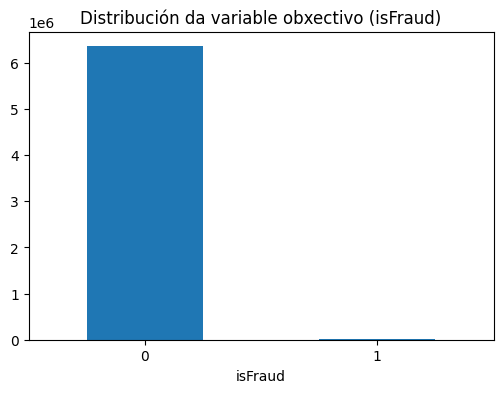

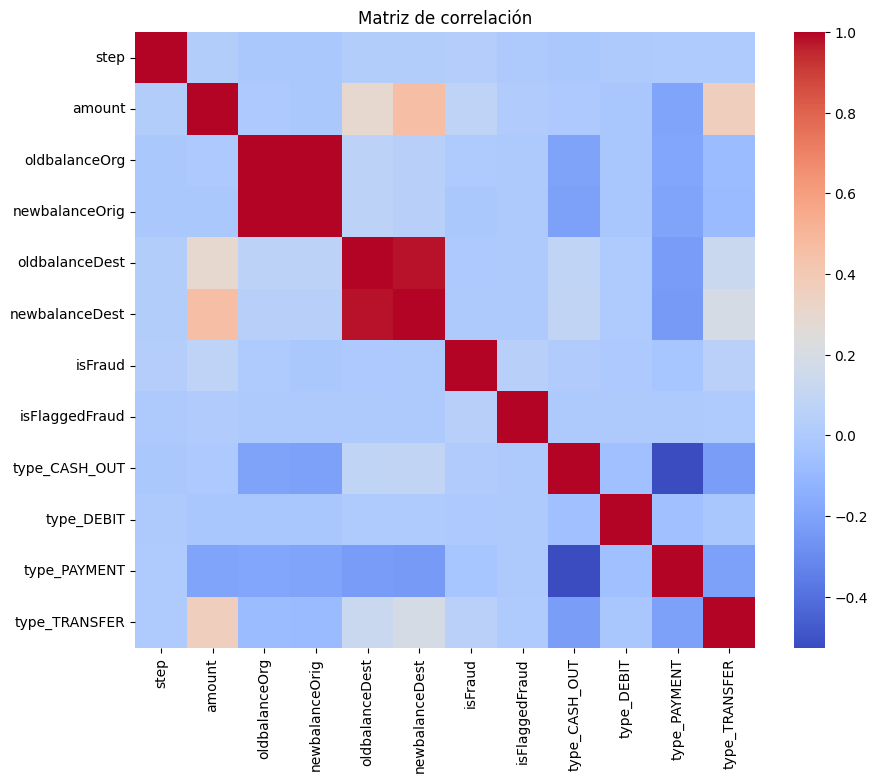

In [10]:
# PASO 2: Cargar o arquivo CSV
file_path = "/content/drive/MyDrive/Dataset.csv"  # Axusta se o teu arquivo está noutra ruta
df = pd.read_csv(file_path)
print(df.info())
print(df.head())
print(df.describe())

# PASO 3: Análise de valores nulos e duplicados
print("Valores nulos por columna:\n", df.isnull().sum())
print("\nDuplicados:", df.duplicated().sum())

# Eliminar duplicados e filas con nulos (se os houbese)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# PASO 4: One-Hot Encoding para variables categóricas
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# PASO 5: Eliminar columnas non numéricas que non se usarán para a correlación/escalado
df = df.drop(['nameOrig', 'nameDest'], axis=1, errors='ignore')

# PASO 6: Análise exploratorio
plt.figure(figsize=(6, 4))
df['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribución da variable obxectivo (isFraud)")
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Matriz de correlación")
plt.show()

In [ ]:
# PASO 8: Tratamiento de datos e importación de más librerías

X = df.drop(['isFraud'], axis=1, errors='ignore')
y = df['isFraud']

# División inicial
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val
)  # 10% validación


print(f"Tamaño entrenamiento: {len(X_train)}")
print(f"Tamaño validación: {len(X_val)}")
print(f"Tamaño test: {len(X_test)}")
print(f"Tasa de fraude en entrenamiento balanceado: {y_train.mean():.2f}")


In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}
best_models = {}


In [11]:
print("Entrenando modelo: Logistic Regression")

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=500, solver="lbfgs"))
])

params = {
    "model__C": [0.5, 1.0, 2.0],
    "model__class_weight": [None, "balanced"]
}

grid = GridSearchCV(pipeline, params, cv=kfold, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

print(f"Mejores parámetros: {grid.best_params_}")
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusión - Logistic Regression (SMOTE en CV)")
plt.show()

results["Logistic Regression"] = {
    "Mejores parámetros": grid.best_params_,
    "F1-score medio (CV)": round(cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='f1').mean(), 4)
}
best_models["Logistic Regression"] = best_model


Entrenando modelo: Logistic Regression


NameError: name 'kfold' is not defined

In [ ]:
print("Entrenando modelo: Decision Tree")

from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipeline = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])


params = {
    # SMOTE más ligero y rápido
    "smote__sampling_strategy": [0.05],  # min:may ≈ 1:20
    "smote__k_neighbors": [3],

    # Árbol acotado (24 combinaciones en total)
    "model__criterion": ["gini"],
    "model__max_depth": [8, 10, 12],
    "model__min_samples_split": [5, 10],
    "model__min_samples_leaf": [2, 4],
    "model__max_features": ["sqrt"],
    "model__class_weight": [None, "balanced"]
}

grid = GridSearchCV(pipeline, params, cv=kfold, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

print(f"Mejores parámetros: {grid.best_params_}")
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusión - Decision Tree (SMOTE en CV)")
plt.show()

results["Decision Tree"] = {
    "Mejores parámetros": grid.best_params_,
    "F1-score medio (CV)": round(cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='f1').mean(), 4)
}
best_models["Decision Tree"] = best_model


In [ ]:
print("Entrenando modelo: Random Forest")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize a RandomForestClassifier with reasonable parameters
# You can further tune these parameters if needed
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Train the model on the training subset
rf_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_val = rf_model.predict(X_val)

print("Resultados en el conjunto de validación:")
print(classification_report(y_val, y_pred_val, digits=4))

cm = confusion_matrix(y_val, y_pred_val)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Store results
results["Random Forest"] = {
    "Mejores parámetros": "Default", # Or add parameters if tuned
    "F1-score en validación": round(classification_report(y_val, y_pred_val, output_dict=True)['1']['f1-score'], 4)
}
best_models["Random Forest"] = rf_model

In [ ]:
print("Entrenando modelo: Linear SVM")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ---------- 1) Submuestra para TUNING (estratificada) ----------
TUNE_MAX_SAMPLES = 200_000
if len(X_train) > TUNE_MAX_SAMPLES:
    frac = TUNE_MAX_SAMPLES / len(X_train)
    X_tune, _, y_tune, _ = train_test_split(
        X_train, y_train, train_size=frac, random_state=42, stratify=y_train
    )
else:
    X_tune, y_tune = X_train, y_train

# ---------- 2) CV=2 para acelerar ----------
cv2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# ---------- 3) Pipeline: scaler -> SMOTE -> LinearSVC ----------
# Usar solo SMOTE para simplificar y evitar conflictos con undersampling
pipeline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("model", LinearSVC(random_state=42, max_iter=5000))
])

# ---------- 4) Grid pequeño y eficiente ----------
params = {
    "model__C": [0.1, 1.0], # Reducir grid
    "model__class_weight": [None, "balanced"],
    "model__dual": [False],    # acelera cuando n_samples >> n_features
    "model__tol": [1e-3]
}

grid = GridSearchCV(
    pipeline, params, cv=cv2, scoring='f1',
    n_jobs=-1, verbose=1
)

# ---------- 5) Tuning en la muestra ----------
grid.fit(X_tune, y_tune)
print(f"Mejores parámetros (tuning): {grid.best_params_}")
print(f"F1 medio (CV=2, tuning): {grid.best_score_:.4f}")

# ---------- 6) Reentrenar mejor pipeline con TODO X_train y evaluar en X_val ----------
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusión - Linear SVM (SMOTE en CV)")
plt.show()

# ---------- 7) Guardar resultados ----------
try:
    results
except NameError:
    results = {}
try:
    best_models
except NameError:
    best_models = {}

results["Linear SVM"] = { # Cambiar nombre para reflejar solo SMOTE
    "Mejores parámetros": grid.best_params_,
    "F1-score medio (CV, tuning)": round(grid.best_score_, 4)
}
best_models["Linear SVM"] = best_model

In [6]:
print("Entrenando modelo: KNN")

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# CV=2 para reducir tiempo
cv2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# --- 1) Submuestra para TUNING (evita fits gigantes) ---
TUNE_MAX_SAMPLES = 150_000
if len(X_train) > TUNE_MAX_SAMPLES:
    frac = TUNE_MAX_SAMPLES / len(X_train)
    X_tune, _, y_tune, _ = train_test_split(
        X_train, y_train, train_size=frac, random_state=42, stratify=y_train
    )
else:
    X_tune, y_tune = X_train, y_train

# --- 2) Pipeline: under -> scaler -> SMOTE (suave) -> KNN ---
pipeline = ImbPipeline(steps=[
    ("under", RandomUnderSampler(sampling_strategy=0.10, random_state=42)),         # ~1:10
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, sampling_strategy=0.20, k_neighbors=3)),       # > 0.10 (p.ej. 0.20 → ~1:5)
    ("model", KNeighborsClassifier(algorithm="ball_tree", n_neighbors=5,
                                   weights="distance", p=2, leaf_size=40, n_jobs=-1))
])

# --- 3) Grid muy compacto (2 combinaciones) ---
params = {
    "model__n_neighbors": [5, 7],      # solo K para comparar
    # dejar el resto fijo para evitar recomputar árboles
}

grid = GridSearchCV(pipeline, params, cv=cv2, scoring='f1', n_jobs=-1, verbose=1)

# --- 4) Tuning en la muestra ---
grid.fit(X_tune, y_tune)
print(f"Mejores parámetros (tuning): {grid.best_params_}")
print(f"F1 medio (CV=2, tuning): {grid.best_score_:.4f}")

# --- 5) Reentrenar el mejor pipeline con TODO X_train y evaluar en X_val ---
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred, digits=4))

cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Matriz de Confusión - KNN (under+SMOTE ligero, CV=2)")
plt.show()

# --- 6) Guardar resultados ---
try:
    results
except NameError:
    results = {}
try:
    best_models
except NameError:
    best_models = {}

results["KNN"] = {
    "Mejores parámetros": grid.best_params_,
    "F1-score medio (CV=2, tuning)": round(grid.best_score_, 4)
}
best_models["KNN"] = best_model


Entrenando modelo: KNN


NameError: name 'X_train' is not defined

In [ ]:
# Comparativa de tiempos y F1 en validación
from sklearn.base import clone
from sklearn.metrics import f1_score
import time
import pandas as pd

timings = []
for name, est in best_models.items():
    est_clone = clone(est)
    t0 = time.perf_counter()
    est_clone.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0

    t1 = time.perf_counter()
    y_pred = est_clone.predict(X_val)
    pred_time = time.perf_counter() - t1

    f1 = f1_score(y_val, y_pred)
    timings.append({
        "Modelo": name,
        "fit_s": round(fit_time, 4),
        "predict_s": round(pred_time, 4),
        "F1_val": round(f1, 4)
    })

df_timings = pd.DataFrame(timings).sort_values(by=["fit_s", "F1_val"], ascending=[True, False]).reset_index(drop=True)
print(df_timings)


In [ ]:
# Exportar tabla a CSV y Excel
csv_path = "comparativa_tiempos_f1.csv"
xlsx_path = "comparativa_tiempos_f1.xlsx"
df_timings.to_csv(csv_path, index=False)
df_timings.to_excel(xlsx_path, index=False)
print("CSV guardado en:", csv_path)
print("Excel guardado en:", xlsx_path)


In [ ]:
# Gráficas (matplotlib) de tiempos y F1
import matplotlib.pyplot as plt

# Ordenar por tiempo de entrenamiento
_order_fit = df_timings.sort_values("fit_s", ascending=True)
plt.figure()
plt.barh(_order_fit["Modelo"], _order_fit["fit_s"])
plt.xlabel("Tiempo de entrenamiento (s)")
plt.ylabel("Modelo")
plt.title("Tiempo de entrenamiento por modelo")
plt.tight_layout()
plt.show()

# Ordenar por F1 de validación
_order_f1 = df_timings.sort_values("F1_val", ascending=False)
plt.figure()
plt.barh(_order_f1["Modelo"], _order_f1["F1_val"])
plt.xlabel("F1 en validación")
plt.ylabel("Modelo")
plt.title("F1 (validación) por modelo")
plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path
from datetime import datetime

assert 'df_timings' in globals(), "df_timings no existe aún. Ejecuta primero la celda de benchmarking."

best_f1_row = df_timings.sort_values("F1_val", ascending=False).iloc[0]
fastest_row = df_timings.sort_values("fit_s", ascending=True).iloc[0]

resumen_md = f"""
# Resumen de benchmarking (SMOTE + Pipelines)

**Fecha:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Mejor F1 (validación)
- **Modelo:** {best_f1_row['Modelo']}
- **F1_val:** {best_f1_row['F1_val']}
- **Tiempo de entrenamiento (s):** {best_f1_row['fit_s']}
- **Tiempo de predicción (s):** {best_f1_row['predict_s']}

## Modelo más rápido (entrenamiento)
- **Modelo:** {fastest_row['Modelo']}
- **F1_val:** {fastest_row['F1_val']}
- **Tiempo de entrenamiento (s):** {fastest_row['fit_s']}
- **Tiempo de predicción (s):** {fastest_row['predict_s']}

## Tabla completa
{df_timings.to_markdown(index=False)}
"""

out_md = Path("benchmark_resumen.md")
out_html = Path("benchmark_resumen.html")

out_md.write_text(resumen_md, encoding="utf-8")

html_head = "<html><head><meta charset='utf-8'><title>Resumen Benchmark</title></head><body>"
html_tail = "</body></html>"
table_html = df_timings.to_html(index=False)
html = f"""{html_head}
<h1>Resumen de benchmarking (SMOTE + Pipelines)</h1>
<p><strong>Fecha:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
<h2>Mejor F1 (validación)</h2>
<ul>
  <li><strong>Modelo:</strong> {best_f1_row['Modelo']}</li>
  <li><strong>F1_val:</strong> {best_f1_row['F1_val']}</li>
  <li><strong>Tiempo de entrenamiento (s):</strong> {best_f1_row['fit_s']}</li>
  <li><strong>Tiempo de predicción (s):</strong> {best_f1_row['predict_s']}</li>
</ul>
<h2>Modelo más rápido (entrenamiento)</h2>
<ul>
  <li><strong>Modelo:</strong> {fastest_row['Modelo']}</li>
  <li><strong>F1_val:</strong> {fastest_row['F1_val']}</li>
  <li><strong>Tiempo de entrenamiento (s):</strong> {fastest_row['fit_s']}</li>
  <li><strong>Tiempo de predicción (s):</strong> {fastest_row['predict_s']}</li>
</ul>
<h2>Tabla completa</h2>
{table_html}
{html_tail}"""
out_html.write_text(html, encoding="utf-8")

print("Resumen guardado en:")
print("- Markdown:", out_md.resolve())
print("- HTML:", out_html.resolve())
